## Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt

import sys
sys.path.append("..")
from analysis.analysis_modules.load_data import LoadData
from analysis.analysis_modules.data_checks import BasicDataChecks

### Set Global Variables

In [2]:
PATH = "D:\\Code\\Projects\\5Swans\\storage\\trade"
CURRENCY = "AUD_SGD_XRP"
pair1, pair2, pair3 = "AUD_SGD", "XRP_AUD", "XRP_SGD"

### Load Data

In [3]:
# data_obj = LoadData(PATH, CURRENCY, pair1, pair2, pair3)
# data = data_obj.price_data

data_obj = BasicDataChecks("data_XRP.pkl")
data = data_obj.data

### Basic Data Checks

In [4]:
data_obj.check

----------------------------------------------------------------------------------------------------
Data head: 
                            AUD_SGD          XRP_AUD          XRP_SGD             trade          
                            bestBid  bestAsk bestBid bestAsk  bestBid bestAsk    trade0    trade1
2022-04-12 13:11:03.578656  1.01398   1.0141  0.9495  0.9505  0.95597  0.9611 -0.008229  0.001742
2022-04-12 13:11:06.754743  1.01398   1.0141  0.9495  0.9505  0.95597  0.9611 -0.008229  0.001742
2022-04-12 13:11:09.829060    1.014  1.01413  0.9495  0.9505  0.95597  0.9611 -0.008258  0.001762
2022-04-12 13:11:13.065116    1.014  1.01413  0.9495  0.9505  0.95597  0.9611 -0.008258  0.001762
2022-04-12 13:11:16.125246    1.014  1.01413  0.9495  0.9505  0.95597  0.9611 -0.008258  0.001762
----------------------------------------------------------------------------------------------------
Data tail:  
                            AUD_SGD          XRP_AUD         XRP_SGD              trade

---
## How Long Does the Arbitrage Opportunity Stay?

Clearly, there are repeated values. However, the timestamps are unique. It implies that an arbitrage opportunity exists for some period of time before vanishing. Let us analyse for how long does the arbitrage exist.

### Number of Times Arbitrage Opportunity Was Scanned

In [40]:
data["trade"][data["trade"] > 0].count()/data["trade"].count()

trade0    0.000000
trade1    0.377741
dtype: float64

<AxesSubplot:ylabel='Frequency'>

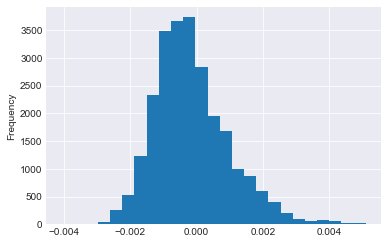

In [24]:
data["trade"]["trade1"].plot(kind='hist', bins=25)

<AxesSubplot:>

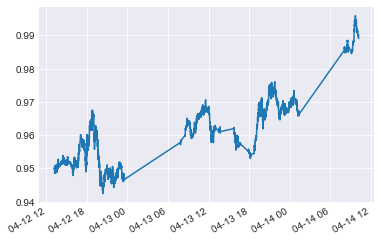

In [17]:
data["XRP_AUD"].mean(axis=1).plot()

In [11]:
y = data["trade"]["trade1"][data["trade"]["trade1"] > 0]
y[y.duplicated(keep=False)][:20]

2022-04-12 13:11:03.578656    0.001742
2022-04-12 13:11:06.754743    0.001742
2022-04-12 13:11:09.829060    0.001762
2022-04-12 13:11:13.065116    0.001762
2022-04-12 13:11:16.125246    0.001762
2022-04-12 13:11:28.710682      0.0019
2022-04-12 13:11:31.778883      0.0019
2022-04-12 13:11:34.846607    0.001801
2022-04-12 13:11:37.939428    0.001801
2022-04-12 13:11:40.998869    0.001811
2022-04-12 13:11:44.082462    0.001811
2022-04-12 13:11:47.211922    0.001811
2022-04-12 13:11:56.474859    0.001692
2022-04-12 13:11:59.628255    0.001692
2022-04-12 13:12:02.735580    0.001682
2022-04-12 13:12:05.835453    0.001712
2022-04-12 13:12:09.064202    0.001712
2022-04-12 13:12:12.146404    0.001712
2022-04-12 13:12:15.196955    0.001712
2022-04-12 13:12:18.244169    0.001702
Name: trade1, dtype: object

In [6]:
x = data["trade"]["trade1"][data["trade"]["trade1"] > 0]
(1 + x[~x.duplicated(keep='first')]).cumprod()

2022-04-12 13:11:03.578656      1.001742
2022-04-12 13:11:09.829060      1.003506
2022-04-12 13:11:19.433671      1.005343
2022-04-12 13:11:22.513109      1.007273
2022-04-12 13:11:25.569281      1.009167
                                 ...    
2022-04-14 09:41:57.072381    807.888178
2022-04-14 09:42:03.360056    808.611083
2022-04-14 09:42:06.666919    809.237237
2022-04-14 09:43:32.564562    809.823721
2022-04-14 09:43:39.285422    810.442777
Name: trade1, Length: 6336, dtype: object